In [1]:
import os
import copy
import pickle
import sympy
import functools
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from error_injection import MissingValueError, SamplingError, Injector
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import mutual_info_score, auc, roc_curve, roc_auc_score, f1_score
from scipy.optimize import minimize as scipy_min
from scipy.spatial import ConvexHull
from scipy.optimize import minimize, Bounds, linprog
from sympy import Symbol as sb
from sympy import lambdify
from tqdm.notebook import trange,tqdm
from IPython.display import display,clear_output
from random import choice
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

class style():
    RED = '\033[31m'
    GREEN = '\033[32m'
    BLUE = '\033[34m'
    RESET = '\033[0m'

np.random.seed(1)

# ignore all the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# first impute the data and make it hypothetically clean
def load_mpg_cleaned():
    # fetch dataset
    auto_mpg = pd.read_csv('auto-mpg.csv').drop('car name', axis=1).replace('?', np.nan)
    
    features = ['cylinders', 'displacement', 'horsepower', 'weight',
                'acceleration', 'model year', 'origin']
    X = auto_mpg[features].astype(float)
    y = auto_mpg['mpg']
    
    # assumed gt imputation
    imputer = KNNImputer(n_neighbors=10)
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train = copy.deepcopy(X_train).reset_index(drop=True)
    X_test = copy.deepcopy(X_test).reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = load_mpg_cleaned()

In [3]:
#Useful functions
symbol_id = -1
def create_symbol(suffix=''):
    global symbol_id
    symbol_id += 1
    name = f'e{symbol_id}_{suffix}' if suffix else f'e{symbol_id}'
    return sympy.Symbol(name=name)


scaler_symbols = set([sb(f'k{i}') for i in range(X_train.shape[1]+1)])
linearization_dict = dict()
reverse_linearization_dict = dict()

def inject_sensitive_ranges(X, y, uncertain_attr, uncertain_num, boundary_indices, uncertain_radius_pct=None, 
                  uncertain_radius=None, seed=42):
    global symbol_id
    symbol_id = -1
    
    X_extended = np.append(np.ones((len(X), 1)), X, axis=1)
    ss = StandardScaler()
    X_extended[:, 1:] = ss.fit_transform(X_extended[:, 1:])
    X_extended_symb = sympy.Matrix(X_extended)
    
    if not(uncertain_attr=='y'):
        uncertain_attr_idx = X.columns.to_list().index(uncertain_attr) + 1
        if not(uncertain_radius):
            uncertain_radius = uncertain_radius_pct*(np.max(X_extended[:, uncertain_attr_idx])-\
                                                     np.min(X_extended[:, uncertain_attr_idx]))
    else:
        if not(uncertain_radius):
            uncertain_radius = uncertain_radius_pct*(y_train.max()-y_train.min())[0]
    
    np.random.seed(seed)
    uncertain_indices = boundary_indices[:uncertain_num]
    y_symb = sympy.Matrix(y)
    symbols_in_data = set()
    #print(uncertain_indices)
    for uncertain_idx in uncertain_indices:
        new_symb = create_symbol()
        symbols_in_data.add(new_symb)
        if uncertain_attr=='y':
            y_symb[uncertain_idx] = y_symb[uncertain_idx] + uncertain_radius*new_symb
        else:
            X_extended_symb[uncertain_idx, uncertain_attr_idx] = X_extended_symb[uncertain_idx, uncertain_attr_idx] + uncertain_radius*new_symb
    return X_extended_symb, y_symb, symbols_in_data, ss

# if interval=True, use interval arithmetic, otherwise use zonotopes
def compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, robustness_radius,
                                         uncertain_num, boundary_indices, uncertain_radius=None, 
                                         lr=0.1, seed=42, interval=True):
    X, y, symbols_in_data, ss = inject_sensitive_ranges(X=X_train, y=y_train, uncertain_attr='y', 
                                              uncertain_num=uncertain_num, boundary_indices=boundary_indices, 
                                              uncertain_radius=uncertain_radius, 
                                              uncertain_radius_pct=None, seed=seed)
    
    assert len(X.free_symbols)==0
    # closed-form
    param = (X.T*X).inv()*X.T*y
    
    if interval:
        # make param intervals
        for d in range(len(param)):
            expr = param[d]
            if not(expr.free_symbols):
                continue
            else:
                constant_part = 0
                interval_radius = 0
                for arg in expr.args:
                    if arg.free_symbols:
                        interval_radius += abs(arg.args[0])
                    else:
                        assert constant_part == 0
                        constant_part = arg
                param[d] = constant_part + create_symbol()*interval_radius
    
    test_preds = sympy.Matrix(np.append(np.ones((len(X_test), 1)), ss.transform(X_test), axis=1))*param
    robustness_ls = []
    for pred in test_preds:
        pred_range_radius = 0
        for arg in pred.args:
            if arg.free_symbols:
                pred_range_radius += abs(arg.args[0])
        if pred_range_radius <= robustness_radius:
            robustness_ls.append(1)
        else:
            robustness_ls.append(0)
    
#     print(param)
    return np.mean(robustness_ls)

def inject_ranges(X, y, uncertain_attr, uncertain_num, uncertain_radius_pct=None, uncertain_radius=None, seed=42):
    global symbol_id
    symbol_id = -1
    
    X_extended = np.append(np.ones((len(X), 1)), X, axis=1)
    ss = StandardScaler()
    X_extended[:, 1:] = ss.fit_transform(X_extended[:, 1:])
    X_extended_symb = sympy.Matrix(X_extended)
    
    if not(uncertain_attr=='y'):
        uncertain_attr_idx = X.columns.to_list().index(uncertain_attr) + 1
        if not(uncertain_radius):
            uncertain_radius = uncertain_radius_pct*(np.max(X_extended[:, uncertain_attr_idx])-\
                                                     np.min(X_extended[:, uncertain_attr_idx]))
    else:
        if not(uncertain_radius):
            uncertain_radius = uncertain_radius_pct*(y_train.max()-y_train.min())[0]
    
    np.random.seed(seed)
    uncertain_indices = np.random.choice(range(len(y)), uncertain_num, replace=False)
    y_symb = sympy.Matrix(y)
    symbols_in_data = set()
    for uncertain_idx in uncertain_indices:
        new_symb = create_symbol()
        symbols_in_data.add(new_symb)
        if uncertain_attr=='y':
            y_symb[uncertain_idx] = y_symb[uncertain_idx] + uncertain_radius*new_symb
        else:
            X_extended_symb[uncertain_idx, uncertain_attr_idx] = X_extended_symb[uncertain_idx, uncertain_attr_idx] + uncertain_radius*new_symb
    return X_extended_symb, y_symb, symbols_in_data, ss

# if interval=True, use interval arithmetic, otherwise use zonotopes
def compute_robustness_ratio_label_error(X_train, y_train, X_test, y_test, robustness_radius,
                                         uncertain_num, uncertain_radius=None, 
                                         lr=0.1, seed=42, interval=True):
    X, y, symbols_in_data, ss = inject_ranges(X=X_train, y=y_train, uncertain_attr='y', 
                                              uncertain_num=uncertain_num, uncertain_radius=uncertain_radius, 
                                              uncertain_radius_pct=None, seed=seed)
    
    assert len(X.free_symbols)==0
    # closed-form
    param = (X.T*X).inv()*X.T*y
    
    if interval:
        # make param intervals
        for d in range(len(param)):
            expr = param[d]
            if not(expr.free_symbols):
                continue
            else:
                constant_part = 0
                interval_radius = 0
                for arg in expr.args:
                    if arg.free_symbols:
                        interval_radius += abs(arg.args[0])
                    else:
                        assert constant_part == 0
                        constant_part = arg
                param[d] = constant_part + create_symbol()*interval_radius
    
    test_preds = sympy.Matrix(np.append(np.ones((len(X_test), 1)), ss.transform(X_test), axis=1))*param
    robustness_ls = []
    for pred in test_preds:
        pred_range_radius = 0
        for arg in pred.args:
            if arg.free_symbols:
                pred_range_radius += abs(arg.args[0])
        if pred_range_radius <= robustness_radius:
            robustness_ls.append(1)
        else:
            robustness_ls.append(0)
    
#     print(param)
    return np.mean(robustness_ls)
    

In [4]:
#accuracy r2 = True; rmse, mse = False for maximize
def leave_one_out(X_train, y_train, X_test, y_test, model, metric, maximize=True): 
    predictions = model.fit(X_train, y_train).predict(X_test)
    initial_metric = metric(y_test.to_numpy(), predictions)
    influence_results = []
   
    for i in range(len(X_train)):
        X_train_new = np.delete(X_train, i, axis=0)
        y_train_new = np.delete(y_train, i, axis=0)
       
        model_clone = model.__class__(**model.get_params())
        new_preds = model_clone.fit(X_train_new, y_train_new).predict(X_test)
        new_metric = metric(y_test.to_numpy(), new_preds)
       
        metric_diff = (initial_metric - new_metric) if maximize else (new_metric - initial_metric)
        
        influence_results.append((i, metric_diff))
       
       
   
    influence_results = sorted(influence_results,key=lambda x: x[1], reverse=True)
    #print(influence_results)
    return [i[0] for i in influence_results]

def mae(y_true, y_pred):
    return sum(abs(y_true - y_pred))/len(y_true)

def mse(y_true, y_pred):
    return sum((y_true - y_pred)**2)/len(y_true)

def r_squared(y_true, y_pred):
    y_bar = np.mean(y_true)
    return 1 -(sum((y_true - y_pred)**2)/sum((y_true-y_bar)**2))

def rmse(y_true, y_pred):
    return np.sqrt(sum((y_true - y_pred)**2)/len(y_true))

In [5]:
lr = LinearRegression()
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, lr, mae, maximize=False)

In [6]:
# Decision Tree research: 1% of the data
array_indexes = np.zeros(len(X_train))
perc = 0.1 * len(X_train)
for i in range(0, len(X_train)):
    if i <= perc:
        index = boundary_indices[i]
        array_indexes[index] = 1

clf = DecisionTreeClassifier(max_depth=None)
clf.fit(X_train, array_indexes)

feature_max_values = X_train.max()

def get_positive_paths(tree, feature_names, node=0, depth=0, conditions=None, results=None, min_positive_ratio=0.5):
    if conditions is None:
        conditions = {}
    if results is None:
        results = []

    left_child = tree.children_left[node]
    right_child = tree.children_right[node]
    threshold = tree.threshold[node]
    feature = tree.feature[node]

    # Count samples in this node
    sample_count = int(tree.n_node_samples[node])
    positive_count = int(tree.value[node][0, 1]) if tree.n_outputs == 1 else int(tree.value[node][0][1])
    negative_count = int(tree.value[node][0, 0]) if tree.n_outputs == 1 else int(tree.value[node][0][0])

    # Calculate the positive ratio for this node
    positive_ratio = positive_count / sample_count if sample_count > 0 else 0

    # If it's a leaf or qualifies as a 'positive node' by ratio, store the path
    if (left_child == _tree.TREE_LEAF and right_child == _tree.TREE_LEAF) or positive_ratio >= min_positive_ratio:
        path_conditions = {}
        for feat, bounds in conditions.items():
            lower_bound = bounds.get('lower', 0)
            upper_bound = bounds.get('upper', feature_max_values.get(feat, '∞'))  # Use the max value for the feature
            path_conditions[feat] = (lower_bound, upper_bound)
        
        # Only store if there are significant positives
        if positive_count > 0:  # Ensure that there's at least one positive sample
            results.append((positive_count, sample_count, path_conditions, positive_ratio, depth))

    # Update bounds for the current feature in conditions and recurse
    feature_name = feature_names[feature] if feature != _tree.TREE_UNDEFINED else None
    if left_child != _tree.TREE_LEAF and feature_name:
        # Left child represents the <= threshold split
        new_conditions = {k: v.copy() for k, v in conditions.items()}
        new_conditions.setdefault(feature_name, {}).update({'upper': threshold})
        get_positive_paths(tree, feature_names, left_child, depth + 1, new_conditions, results, min_positive_ratio)

    if right_child != _tree.TREE_LEAF and feature_name:
        # Right child represents the > threshold split
        new_conditions = {k: v.copy() for k, v in conditions.items()}
        new_conditions.setdefault(feature_name, {}).update({'lower': threshold})
        get_positive_paths(tree, feature_names, right_child, depth + 1, new_conditions, results, min_positive_ratio)

    # Print and store paths after completing all nodes, if we are at the root node
    if node == 0:
        # Sort results first by depth (root to leaf), then by positive ratio, and then by positive count
        top_results = sorted(results, key=lambda x: (x[4], x[3], x[0]), reverse=False)[:3]  # Prioritize by depth first
        
        # Store top thresholds
        top_thresholds = []
        for idx, (pos_count, total_count, conditions, pos_ratio, dep) in enumerate(top_results, start=1):
            top_thresholds.append(conditions)  # Save conditions (thresholds) for each scenario    
        return top_thresholds
            
tree = clf.tree_
feature_names = X_train.columns
best_thresholds = get_positive_paths(tree, feature_names)
best_thresholds

[{'horsepower': (205.0, 230.0), 'weight': (3682.0, 5140.0)},
 {'horsepower': (0, 205.0),
  'model year': (0, 71.5),
  'weight': (4739.0, 5140.0)},
 {'horsepower': (0, 92.5),
  'model year': (71.5, 82.0),
  'displacement': (199.0, 455.0),
  'weight': (0, 3001.0)}]

In [7]:
def filter_important_rows(data, thresholds):
    important_indices = set() #makes set to prevent duplicates
    
    for condition in thresholds: 
        mask = np.ones(len(data), dtype=bool)  # Start with all rows as True
        for feature, (min_val, max_val) in condition.items():  #for all each threshold in the dictionary value
            mask &= (data[feature] >= min_val) & (data[feature] <= max_val) # check the following is true (read this as "1/0 and (data[feature] > min_val) and (data[feature] <= max_val)

        important_indices.update(data.index[mask])

    return list(important_indices)
boundary_indices = filter_important_rows(X_train, best_thresholds)

In [8]:
boundary_indices

[291, 262, 204, 108, 302, 175, 272, 305, 84, 21, 118]

In [9]:
len(boundary_indices)

11

In [10]:
# Testing more extreme uncertain percentages
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 0.25
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 12)/1000)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
robustness_dicts_naive = []
for seed in tqdm(range(5), desc=f'Progress'):
    robustness_radius = 0.25
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 12)/1000)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc=f'Rep {seed+1}', leave=False):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius', leave=False):
            robustness_ratio = compute_robustness_ratio_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts_naive.append(robustness_dict)

Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Rep 1:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Rep 2:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Rep 3:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Rep 4:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Rep 5:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
# Testing more extreme uncertain percentages
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 0.25
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 12)/1000)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num,
                                                                    boundary_indices=boundary_indices,
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
robustness_dicts_interval_naive = []
for seed in tqdm(range(5), desc=f'Progress'):
    # mpg +- 2 is robust
    robustness_radius = 0.25
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 12)/1000)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc=f'Rep {seed+1}', leave=False):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius', leave=False):
            robustness_ratio = compute_robustness_ratio_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval_naive.append(robustness_dict_interval)

Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Rep 1:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Rep 2:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Rep 3:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Rep 4:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Rep 5:   0%|          | 0/11 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

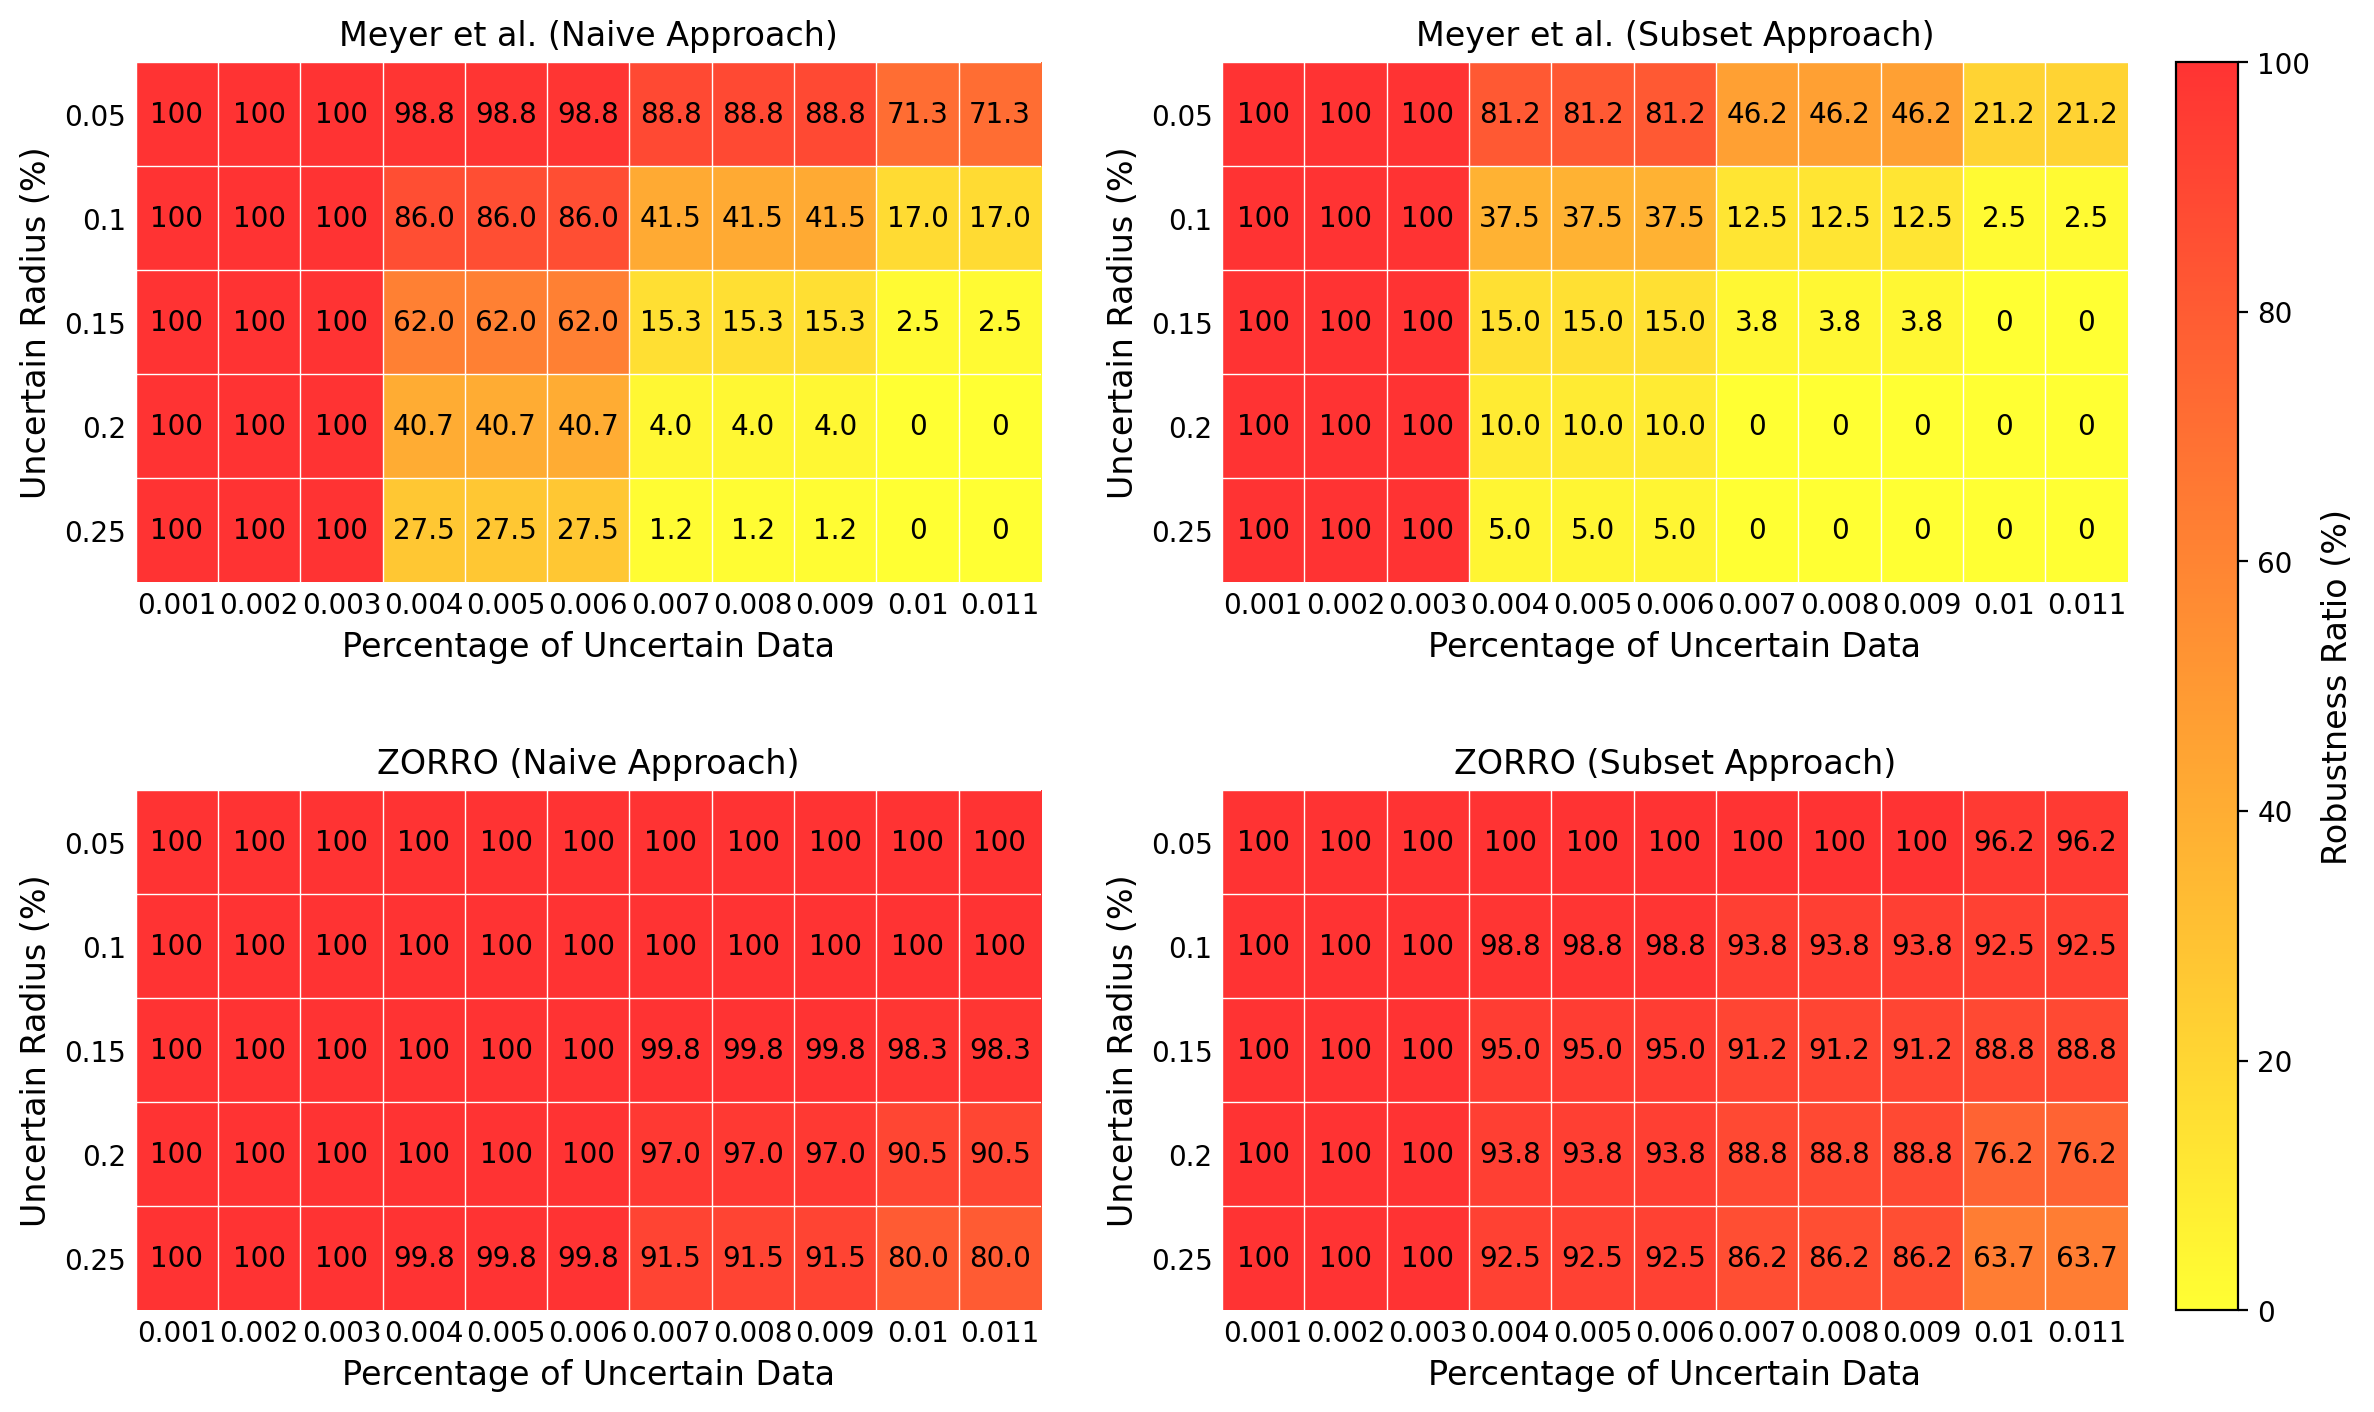

In [14]:
# Create the heatmap plot with a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 8), dpi=200)

# Define colormap
cmap = plt.get_cmap("autumn_r")

# Function to plot a single heatmap
def plot_heatmap(ax, heatmap_data, x_labels, y_labels, title):
    heatmap = ax.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                        aspect='auto', alpha=0.8, vmin=0, vmax=100)
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    ax.tick_params(axis='both', which='both', length=0)  # Remove tick marks
    
    # Add white lines by adjusting the linewidth for minor ticks
    ax.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
    ax.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
    ax.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
    ax.tick_params(which="minor", size=0)
    
    # Remove external boundaries
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Add text annotations
    for i in range(len(y_labels)):
        for j in range(len(x_labels)):
            if heatmap_data[i][j] == 100:
                text = ax.text(j, i, '100', ha='center', va='center', color='black')
            elif heatmap_data[i][j] == 0:
                text = ax.text(j, i, '0', ha='center', va='center', color='black')
            else:
                text = ax.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')

    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Percentage of Uncertain Data', fontsize=12)
    ax.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Data for the heatmaps
df1 = sum([pd.DataFrame(robustness_dicts_interval_naive[i]).iloc[:, 2:] for i in range(5)])/5
df2 = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
df3 = sum([pd.DataFrame(robustness_dicts_naive[i]).iloc[:, 2:] for i in range(5)])/5  # Replace with actual data for heatmap 3
df4 = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5  # Replace with actual data for heatmap 4

# Convert fractions to percentages
heatmap_data1 = df1.multiply(100).values
heatmap_data2 = df2.multiply(100).values
heatmap_data3 = df3.multiply(100).values
heatmap_data4 = df4.multiply(100).values

# Labels
x_labels = df1.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Plot each heatmap
plot_heatmap(axes[0, 0], heatmap_data1, x_labels, y_labels, 'Meyer et al. (Naive Approach)')
plot_heatmap(axes[0, 1], heatmap_data2, x_labels, y_labels, 'Meyer et al. (Subset Approach)')
plot_heatmap(axes[1, 0], heatmap_data3, x_labels, y_labels, 'ZORRO (Naive Approach)')
plot_heatmap(axes[1, 1], heatmap_data4, x_labels, y_labels, 'ZORRO (Subset Approach)')

# Adjust layout and add colorbar
plt.subplots_adjust(wspace=0.2, hspace=0.4, bottom=0.1, left=0.1, right=0.9)
cb = fig.colorbar(axes[0, 1].images[0], ax=axes, orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('graph_outs/subset_injection_mpg_linearReg_mae.pdf', bbox_inches='tight')